# sbpy.photometry: Disk-integrated phase function

[sbpy.photometry](https://sbpy.readthedocs.io/en/latest/sbpy/photometry.html) defines the classes to implement the IAU-adopted disk-integrated phase function models for (atmosphereless) solar system objects.  The models currently implemented include a linear phase function model, IAU HG model, HG$_1$G$_2$ model, HG$_{12}$ model, and the revised HG$_{12}$ model by [Penttilä et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016P%26SS..123..117P/abstract).

## Disk-integrated phase function

Disk-integrated phase function can be defined by the magnitude or by the average bidirectional reflectance over the whole cross-section of the object with respect to the observer (both illuminated and unilluminated), as a function of solar phase angle.

The magnitude of an object is,

$M(\alpha, r_h, \Delta) = \Phi(\alpha) + 5\log_{10}(r_h) + 5\log_{10}(\Delta)$,

where $\alpha$ is phase angle, $r_h$ is heliocentric distance, and $\Delta$ is the distance to observer.  $\Phi(\alpha)$ is the disk-integrated phase function defined in magnitude, or equivalently the reduced magnitude of an object (the magnitude at $r_h=\Delta=1 au$.

Alternatively, the total flux of an object can be expressed by its average bidirectional reflectance over the whole cross-sectional area,

$f(\alpha, r_h, \Delta) = \frac{\bar r(\alpha) \pi R^2 f_{Sun}}{r^2\Delta^2}$

where $\bar r(\alpha)$ is the disk-integrated phaes function defined by the average bidirectional reflectance, and $R$ is the radius of an object such that $\pi R^2$ is its cross-sectional area.  Note that the phase function $\bar r(\alpha)$ can be normalized to unity at opposition as $\bar r_n(\alpha)$ such that $\bar r_n(0)=1$.  In this case, the geometric albedo of the object $p=\pi \bar r_n(0)$.

The Bond albedo is expressed as,

$A_B = p q$,

where $q$ is phase integral,

$q = 2\int_0^\pi \sin(\alpha) \bar r_n(\alpha)$


## Conversion between magnitude and reflectance

Phase function is defined in either magnitude unit (logarithmic) or in reflectance unit (linear).  The conversion between magnidue and reflectance is supported through [`sbpy.calib`](https://sbpy.readthedocs.io/en/latest/sbpy/calib.html) system and equivalency function [`sbpy.units.reflectance`](https://sbpy.readthedocs.io/en/latest/api/sbpy.units.reflectance.html#sbpy.units.reflectance).

In order to support magnitude-reflectance conversion built inside the photometric model classes, users need to make sure that:
1. Supply the model parameters as `astropy.units.Quantity` instances with the correct units.
1. Supply the radius of the target.
1. Supply and the wavelength/frequency/band of the model that is recognizable by `sbpy.calib` system.

IMPORTANT NOTE:

The photometric model classes defined in `sbpy.photometry` make use of `astropy.modeling.Model` class.  However, the current build of `Model` class does not support `astropy.units.MagUnit` instances for its parameters.  Until this is fixed, users should use only the dimensionless magnitude unit `astropy.units.mag` with `sbpy`'s photometric model class.  Users will also need to supply the corresponding solar flux (magnitude) using `sbpy.calib.solar_fluxd.set` function.

In [9]:
import astropy.units as u
from sbpy.calib import solar_fluxd
from sbpy.photometry import LinearPhaseFunc

linear_phasefunc = LinearPhaseFunc(5 * u.mag, 0.04 * u.mag/u.deg, radius=300 * u.km, wfb='V')
with solar_fluxd.set({'V': -26.77 * u.mag}):
    print('Geometric albedo is {:.4f}'.format(linear_phasefunc.geomalb))
    

Geometric albedo is 0.0487


## Linear phase function model

In this model, the total magnitude of an object is defined by its absolute magnitude $H = M(0, 1, 1)$, and a phase slope $-S$ in magnitude per unit phase angle change.

Geometric albedo is 0.0487
Bond albedo is 0.0179
Phase integral is 0.367


<IPython.core.display.Javascript object>


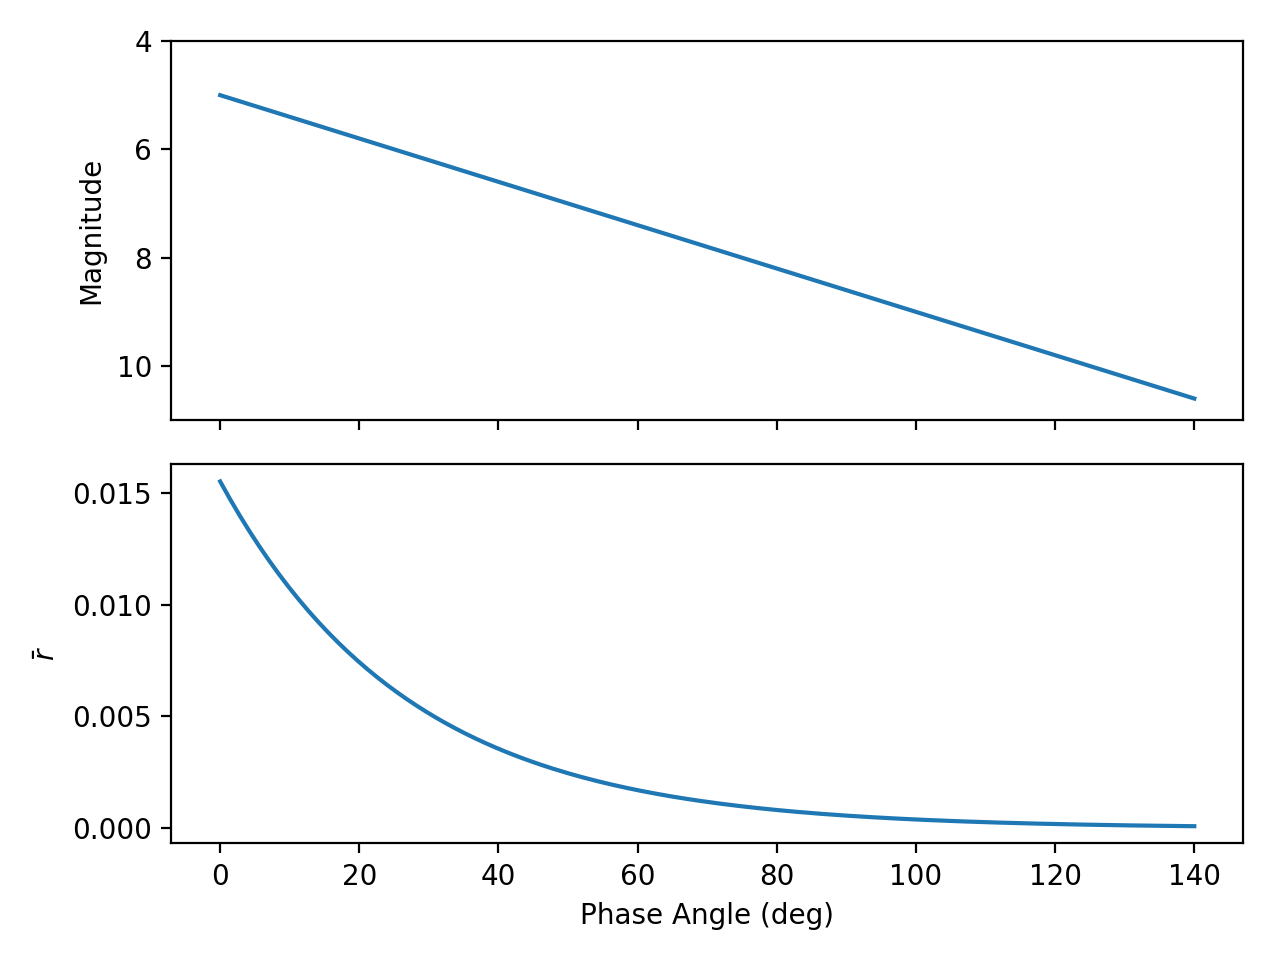

In [10]:
import numpy as np
import astropy.units as u
from sbpy.calib import solar_fluxd
from matplotlib import pyplot as plt
%matplotlib notebook
from sbpy.photometry import LinearPhaseFunc

# Linear phase function with H = 5 and S = 0.04 mag/deg = 2.29 mag/rad
linear_phasefunc = LinearPhaseFunc(5 * u.mag, 0.04 * u.mag/u.deg, radius=300 * u.km, wfb='V')

# set default solar flux in 'V' band
solar_fluxd.set({'V': -26.77 * u.mag})

pha = np.linspace(0, 140, 200) * u.deg
print('Geometric albedo is {0:.3}'.format(linear_phasefunc.geomalb))
print('Bond albedo is {0:.3}'.format(linear_phasefunc.bondalb))
print('Phase integral is {0:.3}'.format(linear_phasefunc.phaseint))

# plot linear phase function
f, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(pha, linear_phasefunc.to_mag(pha))
plt.setp(ax[0], ylabel='Magnitude', ylim=(11, 4))
ax[1].plot(pha, linear_phasefunc.to_ref(pha))

plt.setp(ax[1], xlabel='Phase Angle (deg)', ylabel=r'$\bar r$')
plt.tight_layout()

## IAU HG model

IAU HG model ([Bowell et al. 1989](https://ui.adsabs.harvard.edu/#abs/1989aste.conf..524B/abstract)) describes the disk-integrated phase function of small bodies with two parameters, $H$, and $G$.  The $H$ parameter is the absolute magnitude, and the $G$ parameter describe the slope of the phase function.  Class `photometry.HG` implements this model.

[Muinonen et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010Icar..209..542M/abstract) proposed a 3-parameter model that better describes the disk-integrated phase function of asteroids at phase angles up to 150$^\circ$.  This model was subsequently adopted by the IAU as the new standard asteroid phase function model.  In this model, parameter $H$ is the same as that in the HG model, and parameters $G_1$ and $G_2$ describe the slope of phase function.  Class `photometry.HG1G2` implements the 3-parameter HG$_1$G$_2$ model.

Based on the three-parameter HG$_1$G$_2$ model, [Muinonen et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010Icar..209..542M/abstract) also derived a two-parameter model, in which the phase slope parameter $G_{12}$ is a combination of G$_1$ and G$_2$ parameters that describe the phase slope.  Class `photometry.HG12` implements this 2-parameter HG$_{12}$ model.  [Penttilä et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016P%26SS..123..117P/abstract) further revised the HG$_{12}$ model to overcome a number of shortcomings in the original form, and the revised model is implemented in class `photometry.HG12_Pen16`.

In [11]:
import numpy as np
import astropy.units as u
from astropy.table import Table
from sbpy.calib import solar_fluxd
from sbpy.photometry import HG, HG1G2, HG12

# phase function models for (24) Themis
themis_phase = []
# HG model: H=7.08, G=0.19 (JPL Small Bodies Database)
themis_phase.append(HG(7.08 * u.mag, 0.19, radius=99 * u.km, wfb='V'))
# HG1G2 model: H=7.121, G1=0.67, G2=0.14 (Muinonen et al. 2010)
themis_phase.append(HG1G2(7.121 * u.mag, 0.67, 0.14, radius=99 * u.km, wfb='V'))
# HG12 model: H=7.121, G12=0.68 (Muinonen et al. 2010)
themis_phase.append(HG12(7.121 * u.mag, 0.68, radius=99 * u.km, wfb='V'))

# default solar magnitude
solar_fluxd.set({'V': -26.77 * u.mag})

# photometric properties of Themis based on all three models
geoalb = [m.geomalb for m in themis_phase]   # geometric albedo
bondalb = [m.bondalb for m in themis_phase]   # bond albedo
phaseint = [m.phaseint for m in themis_phase]  # phase integral
oeamp = [m.oe_amp for m in themis_phase[1:]]   # opposition-effect amplitude
oeamp.insert(0,None)
coeff = [m.phasecoeff for m in themis_phase[1:]]   # phase coefficient (slope)
coeff.insert(0,None)

# table of properties
model_names = ['HG', 'HG1G2','HG12']
phopars = Table([model_names, geoalb, bondalb, phaseint, oeamp, coeff],
                names=['Model', 'Geometric Albedo', 'Bond Albedo', 'Phase Integral',
                       'OE Amplitude', 'Phase Coeff'], masked=True)
phopars['OE Amplitude'].mask[0] = True
phopars['Phase Coeff'].mask[0] = True
for k in phopars.keys()[1:]:
    phopars[k].format='%.4f'
phopars.show_in_notebook()


idx,Model,Geometric Albedo,Bond Albedo,Phase Integral,OE Amplitude,Phase Coeff
0,HG,0.0659,0.0270,0.4103,--,--
1,HG1G2,0.0634,0.0250,0.3945,0.2346,-1.6788
2,HG12,0.0634,0.0250,0.3949,0.2341,-1.6777


<IPython.core.display.Javascript object>


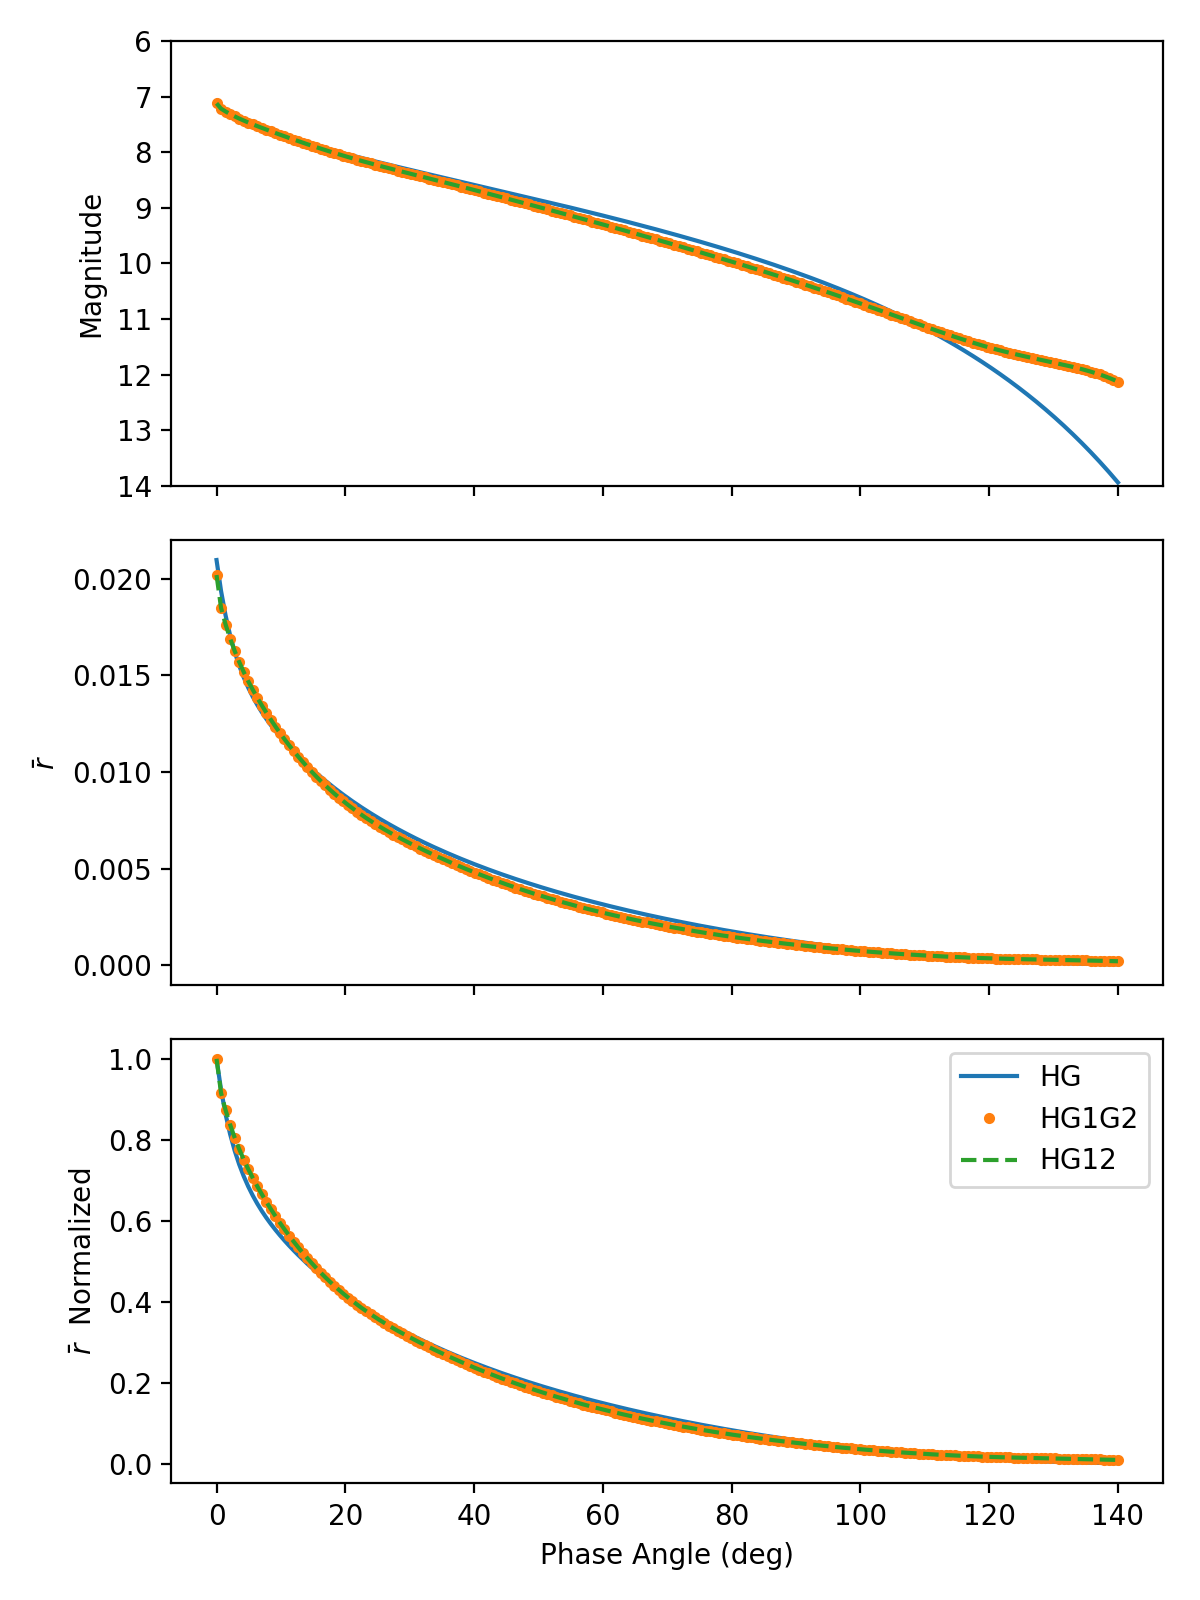

In [12]:
from matplotlib import pyplot as plt
%matplotlib notebook

# plot phase function models for Themis constructed above
pha = np.linspace(0, 140, 200) * u.deg
f, ax = plt.subplots(3, 1, sharex=True, figsize=(6,8))
sym = ['-','.','--']
for m, s in zip(themis_phase,sym):
    ax[0].plot(pha, m.to_mag(pha), s)
    ax[1].plot(pha, m.to_ref(pha), s)
    ax[2].plot(pha, m.to_ref(pha, normalized=0), s)
plt.setp(ax[0], ylabel='Magnitude',ylim=[14,6])
plt.setp(ax[1], ylabel=r'$\bar r$')
plt.setp(ax[2], xlabel='Phase Angle (deg)', ylabel=r'$\bar r$  Normalized')
ax[2].legend(model_names)
plt.tight_layout()

## Plot the predicted magnitude of (24) Themis based on various models

In this example, we used the three different phase function model constructed above to calculate the predicted magnitude of Themis in year 2018, and compare with the prediction by JPL Horizons.  The emphemerides of Themis is generated by JPL Horizons using `data.Ephem` class.

<IPython.core.display.Javascript object>


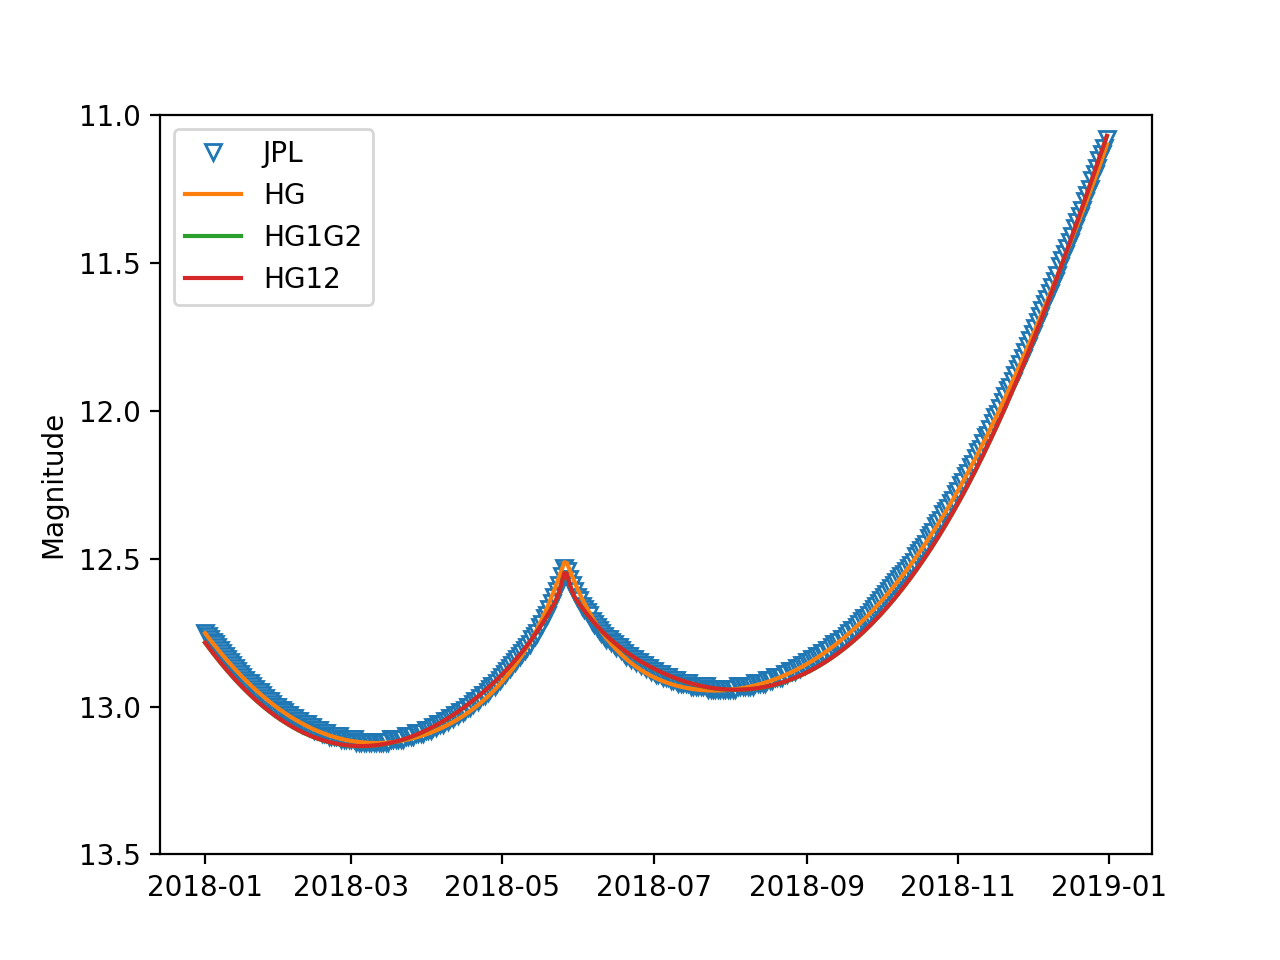

[13.5, 11, Text(0,0.5,'Magnitude')]

In [13]:
import astropy.units as u
from astropy.time import Time
from matplotlib import pyplot as plt
from sbpy.data import Ephem
from sbpy.calib import solar_fluxd

# ephemerides of Themis
epochs = {'start': Time('2018-01-01'), 'stop': Time('2018-12-31'), 'step': 1*u.day}
eph = Ephem.from_horizons('themis', epochs=epochs)

# set up figure
fig = plt.figure()
fig.clear()
ax = fig.gca()

# plot JPL magnitude
ts = Time(eph['epoch'], format='jd')
ax.plot_date(ts.plot_date, eph['V'], 'v', mfc='w')

# plot calculated magnitude
for m in themis_phase:
    ax.plot_date(ts.plot_date, m.to_mag(eph), '-')
ax.legend(['JPL']+model_names)
plt.setp(ax, ylabel='Magnitude', ylim=(13.5,11))

## Define a double-exponential phase function model

In this example, we show how to define a phase function model with `photometry.DiskIntegratedModelClass`.  This model is defined in average bidirectional reflectance with double-exponential function,

$\bar r(\alpha) = \frac{p}{\pi} \frac{1}{1+c} [c\exp(-\alpha/a_1)+\exp(-\alpha/a_2)]$

This model is defined by geometric albedo $p$, parameters $c$ and $a_1$ that characterize the opposition amplitude and width, respectively, and parameter $a_2$ that characterize the phase slope.

geometric albedo = 0.100
bond albedo = 0.031
phase integral = 0.308


<IPython.core.display.Javascript object>


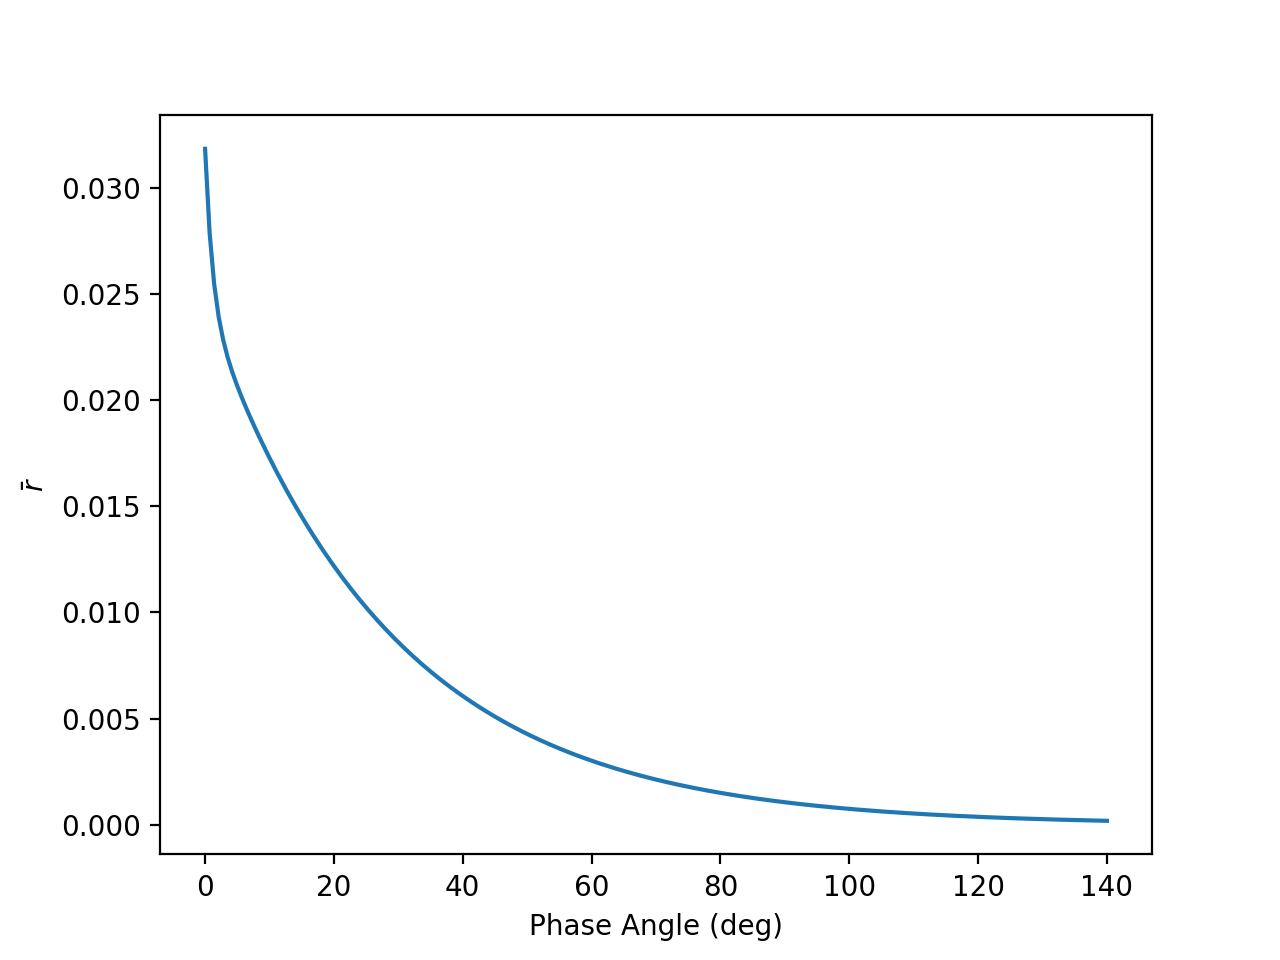

<IPython.core.display.Javascript object>


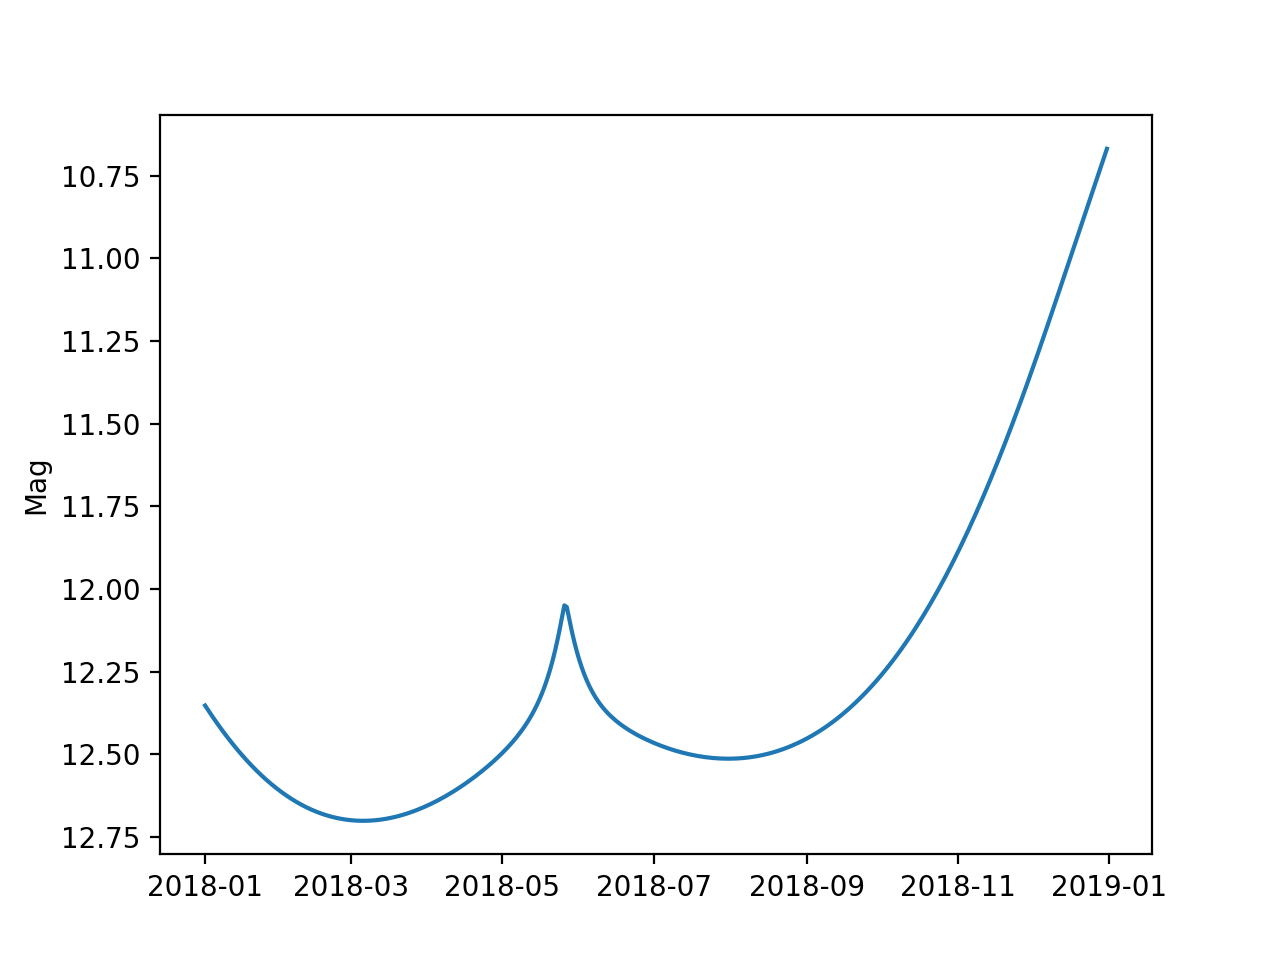

[12.80252011041632, 10.56698198979295, Text(0,0.5,'Mag')]

In [14]:
import numpy as np
import astropy.units as u
from astropy.modeling import Parameter
from astropy.time import Time
from matplotlib import pyplot as plt
%matplotlib notebook
from sbpy.photometry import DiskIntegratedPhaseFunc
from sbpy.data import Ephem
from sbpy.calib import solar_fluxd

# model definition
class DoubleExpPhaseFunc(DiskIntegratedPhaseFunc):
    _unit = 'ref'
    p = Parameter(description='Geometric albedo')
    c = Parameter(description='Opposition effect amplitude')
    a1 = Parameter(description='Opposition effect width')
    a2 = Parameter(description='Phase slope')

    @staticmethod
    def evaluate(a, p, c, a1, a2):
        return p / (np.pi * (1+c)) * (c*np.exp(-a/a1) + np.exp(-a/a2))

solar_fluxd.set({'V': -26.77 * u.mag})

# define a double-exponential phase function and print the basic photometric properties
phasefunc = DoubleExpPhaseFunc(0.1 / u.sr, 0.3, 0.02*u.rad, 0.5*u.rad, radius=100 * u.km, wfb='V')
print('geometric albedo = {0:.3f}'.format(phasefunc.geomalb))
print('bond albedo = {0:.3f}'.format(phasefunc.bondalb))
print('phase integral = {0:.3f}'.format(phasefunc.phaseint))

# plot phase function model
pha = np.linspace(0, 140, 200) * u.deg
fig = plt.figure()
ax = fig.gca()
ax.plot(pha, phasefunc.to_ref(pha))
plt.setp(ax, xlabel='Phase Angle (deg)', ylabel=r'$\bar r$')

# assume this model for (24) Themis, plot its predicted magnitude for year 2018
epochs = {'start': Time('2018-01-01'), 'stop': Time('2018-12-31'), 'step': 1*u.day}
eph = Ephem.from_horizons('themis', epochs=epochs)
ts = Time(eph['epoch'], format='jd')
fig = plt.figure()
fig.clear()
ax = fig.gca()
ax.plot_date(ts.plot_date, phasefunc.to_mag(eph, u.mag), '-')
plt.setp(ax, ylabel='Mag', ylim=ax.axes.get_ylim()[::-1])